<a href="https://colab.research.google.com/github/bodamohannaik/NamedEntityRecognition/blob/master/named_entity_recognition_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition
Named Entity Recognition is a sub task of information extraction, which classifies a chunk of text from unstructed text to a predefined category such as Geographical, Geopolitical, Organization, Person, Event and Time etc

Ref: https://en.wikipedia.org/wiki/Named-entity_recognition

## Download Dataset from Kaggle
https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus

In [1]:
# Install kaggle
!pip install -q kaggle

In [2]:
# configure kaggle
# remove old kaggle.json if you are rerunning this cell again in the same session
!rm -f kaggle.json
# module upload files to colab notebook
from google.colab import files
files.upload()
# remove directory if exists
!rm -rf ~/.kaggle
# create directory
!mkdir ~/.kaggle
# copy file
!cp kaggle.json ~/.kaggle
# Change Permission
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# download dataset and unzip
!kaggle datasets download --unzip abhinavwalia95/entity-annotated-corpus

 83% 22.0M/26.4M [00:00<00:00, 116MB/s] 
100% 26.4M/26.4M [00:00<00:00, 118MB/s]


## Import Modules

In [4]:
# import modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

In [5]:
import random
seed = 33
random.seed(seed)
np.random.seed(seed)

## Load Dataset

In [6]:
# Look at the sample of the ner.csv
ner_df = pd.read_csv('ner.csv', encoding="latin-1", on_bad_lines="skip", index_col=0)
ner_df.head()

,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [7]:
# dataset
def ner_dataset(path):
  """
  Load Tagged NER dataset from path
  :param path: path of the dataset
  :return : Pandas DataFrame
  """
  # CSV file has few bad lines, skip them
  ner_dataset_df = pd.read_csv(path, encoding='latin1', on_bad_lines="skip")
  return ner_dataset_df

In [8]:
# NER dataset
ner_dataset_df = ner_dataset('ner_dataset.csv')
# sample
ner_dataset_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [9]:
# check few more records
ner_dataset_df.head(50)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


## Prepare Sentences and Tags

In [10]:
def get_sentences_and_nes(df):
  """
  Prepare List of sentences and their named entities
  :param df: NER dataset DataFrame
  :return : tuple of list of sentences , list of list of named entities
  """
  df = df.copy(deep=True)
  # fill Sentence Number
  df['Sentence #'].fillna(method="ffill", inplace=True)
  # Group Words by Sentence Number to form Sentence
  grouped_df = df.groupby(by=['Sentence #'], as_index=True).apply(lambda x: pd.Series({'Sentence': " ".join(x['Word'].tolist()), 'Tags':x['Tag'].tolist()}))
  sentences = grouped_df['Sentence'].tolist()
  sentences_tags = grouped_df['Tags'].tolist()
  return sentences, sentences_tags
  


In [11]:
# Get sentences and tags
sentences, sentences_tags = get_sentences_and_nes(df = ner_dataset_df)
print(f"Total sentences: {len(sentences)}")
print(f"Total List of Tags: {len(sentences_tags)}")

Total sentences: 47959
Total List of Tags: 47959


## Visualizations

In [12]:
print("Few sentences and their tags")
for i in range(5):
  print("-"*120)
  print(sentences[i])
  print(sentences_tags[i])

Few sentences and their tags
------------------------------------------------------------------------------------------------------------------------
Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
------------------------------------------------------------------------------------------------------------------------
Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an IAEA surveillance system begins functioning .
['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']
------------------------------------------------------------------------------------------------------------------------
Helicopter gunships Saturday pounded 

In [13]:
def word_count(sentences):
  """
  Unique lower case words count
  :param setences: List of sentences
  return : Count
  """
  all_words = {word.lower() for sentence in sentences for word in sentence.split(" ")}
  return len(all_words)
print(f"Total words: {word_count(sentences)}")


Total words: 31817


In [14]:
all_tags = {tag for sentence_tags in sentences_tags for tag in sentence_tags}
print(f"Total tags: {len(all_tags)}")

Total tags: 17


In [15]:
print(f"All tags: {all_tags}")

All tags: {'B-art', 'I-tim', 'I-geo', 'B-nat', 'B-eve', 'B-geo', 'I-art', 'B-gpe', 'I-per', 'I-eve', 'I-org', 'I-gpe', 'O', 'B-per', 'B-tim', 'B-org', 'I-nat'}


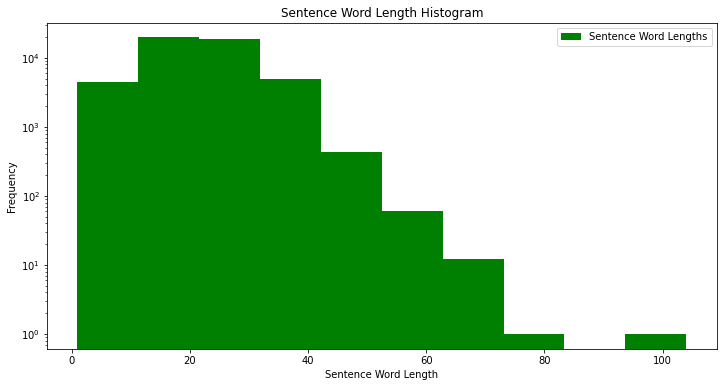

In [16]:
#  plot sentence word lengths 
sentences_lens = [len(sentence.split(" ")) for sentence in sentences]
fig , ax  = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.hist(sentences_lens, color='green', log=True, label='Sentence Word Lengths')
ax.set_xlabel('Sentence Word Length')
ax.set_ylabel('Frequency')
ax.set_title("Sentence Word Length Histogram")
ax.legend()

In [17]:
# Maximum Sentence Length
MAX_SENTENCE_LENGTH = max(sentences_lens)
print(f"Max Sentence Length: {MAX_SENTENCE_LENGTH}")

Max Sentence Length: 104


[('O', 887908), ('B-geo', 37644), ('B-tim', 20333), ('B-org', 20143), ('I-per', 17251), ('B-per', 16990), ('I-org', 16784), ('B-gpe', 15870), ('I-geo', 7414), ('I-tim', 6528), ('B-art', 402), ('B-eve', 308), ('I-art', 297), ('I-eve', 253), ('B-nat', 201), ('I-gpe', 198), ('I-nat', 51)]


Text(0.5, 1.0, 'Tag Counts')

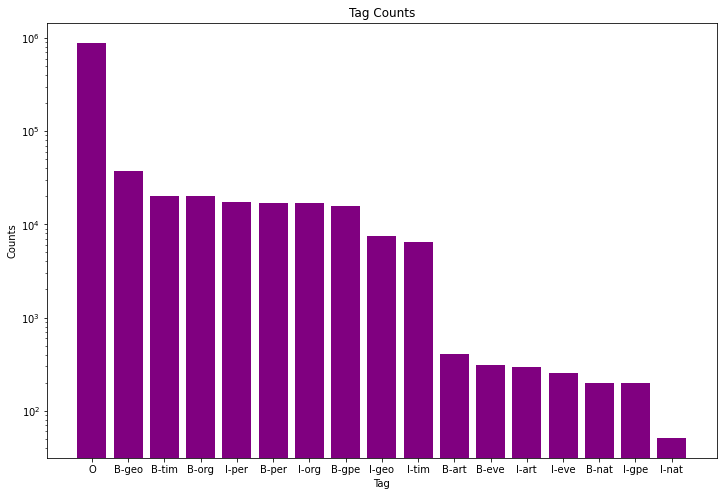

In [18]:
# Tags Occurance Histogram
from collections import Counter

list_of_sentences_tags = [tag for sentence_tags in sentences_tags for tag in sentence_tags]
tag_counts_counter = Counter(list_of_sentences_tags)
tag_counts = tag_counts_counter.most_common()
print(f"{tag_counts}")
tag_names = [x[0] for x in tag_counts]
tag_counts = [x[1] for x in tag_counts]
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.bar(x=tag_names, height=tag_counts, color='purple', log=True)
ax.set_xlabel('Tag')
ax.set_ylabel('Counts')
ax.set_title('Tag Counts')

In [19]:
TAGS_COUNT = len(tag_names)
TAGS_COUNT

17

## Split Dataset

In [20]:
# Split dataset into Train , Validation and Test
from sklearn.model_selection import train_test_split
sentences_train, sentences_test, tags_train, tags_test = train_test_split(sentences, sentences_tags, random_state=seed, test_size=.2)
sentences_test, sentences_val, tags_test, tags_val = train_test_split(sentences_test, tags_test, random_state=seed, test_size=.5)
print(f"Train Sentences:{len(sentences_train)}")
print(f"Train Tags:{len(tags_train)}")
print(f"Validation Sentences:{len(sentences_val)}")
print(f"Validation Tags:{len(tags_val)}")
print(f"Test Sentences:{len(sentences_test)}")
print(f"Test Tags:{len(tags_test)}")

Train Sentences:38367
Train Tags:38367
Validation Sentences:4796
Validation Tags:4796
Test Sentences:4796
Test Tags:4796


## Prepare Data

In [21]:
# Choose Vocabulary Size
print(f"Total words in Train Sentences: {word_count(sentences_train)}")

Total words in Train Sentences: 29073


In [22]:
VOCABULARY_SIZE = 27000
OUTPUT_SEQUENCE_LENGTH = MAX_SENTENCE_LENGTH

In [23]:
# Tokenize the Sentences
sentence_tokenizer = tf.keras.layers.TextVectorization(max_tokens=VOCABULARY_SIZE, standardize='lower', split='whitespace', output_mode='int', output_sequence_length=OUTPUT_SEQUENCE_LENGTH)
sentence_tokenizer.adapt(sentences_train)
sentence_tokenizer.vocabulary_size()

27000

In [24]:
def vectorize_sentences(sentences):
  """
  Convert List of Sentences to Array of tokens
  :param sentences: List of sentences
  :return : Array of tokens padded to OUTPUT_SEQUENCE_LENGTH
  """
  return sentence_tokenizer(sentences)

In [25]:
data_train = vectorize_sentences(sentences = sentences_train)
data_val = vectorize_sentences(sentences = sentences_val)
data_test = vectorize_sentences(sentences = sentences_test)
print(f"Data Train shape : {data_train.shape}")
print(f"Data Val shape : {data_val.shape}")
print(f"Data Test shape : {data_test.shape}")

Data Train shape : (38367, 104)
Data Val shape : (4796, 104)
Data Test shape : (4796, 104)


In [26]:
data_train[:2]

<tf.Tensor: shape=(2, 104), dtype=int64, numpy=
array([[    2,    82,  6942, 21683,     5,     8,   278,     6,  1775,
            4,   142,  4145,     4,     2,  2794,   842,     4,     9,
            2,  6024,   492,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 2280,   482,     2,  1852,  6760, 19845,    72,     5,     1,
         2309,     3,     0,     0,     0,     0,     0,

In [27]:
# Tokenize Tags
tags_tokenizer = tf.keras.layers.StringLookup(max_tokens=None, num_oov_indices=0, mask_token="M-Token", output_mode="int")
tags_tokenizer.adapt(tf.ragged.constant(tags_train))
tags_tokenizer.vocabulary_size()

18

In [28]:
tags_vocab = tags_tokenizer.get_vocabulary()
tags_vocab

['M-Token',
 'O',
 'B-geo',
 'B-tim',
 'B-org',
 'I-per',
 'B-per',
 'I-org',
 'B-gpe',
 'I-geo',
 'I-tim',
 'B-art',
 'I-art',
 'B-eve',
 'I-eve',
 'I-gpe',
 'B-nat',
 'I-nat']

In [29]:
tags2ind = {tag: ind for ind, tag in enumerate(tags_vocab)}
tags2ind

{'M-Token': 0,
 'O': 1,
 'B-geo': 2,
 'B-tim': 3,
 'B-org': 4,
 'I-per': 5,
 'B-per': 6,
 'I-org': 7,
 'B-gpe': 8,
 'I-geo': 9,
 'I-tim': 10,
 'B-art': 11,
 'I-art': 12,
 'B-eve': 13,
 'I-eve': 14,
 'I-gpe': 15,
 'B-nat': 16,
 'I-nat': 17}

In [30]:
ind2tag = {value: key for key, value in tags2ind.items()}
ind2tag

{0: 'M-Token',
 1: 'O',
 2: 'B-geo',
 3: 'B-tim',
 4: 'B-org',
 5: 'I-per',
 6: 'B-per',
 7: 'I-org',
 8: 'B-gpe',
 9: 'I-geo',
 10: 'I-tim',
 11: 'B-art',
 12: 'I-art',
 13: 'B-eve',
 14: 'I-eve',
 15: 'I-gpe',
 16: 'B-nat',
 17: 'I-nat'}

In [31]:
def vectorize_tags(tags):
  """
  Convert Tags to Tokens
  :params tags: List of Sentences tags
  :return : Tokens Array
  """
  v_tags = tags_tokenizer(tf.ragged.constant(tags))
  return tf.keras.preprocessing.sequence.pad_sequences(v_tags.numpy(), maxlen=OUTPUT_SEQUENCE_LENGTH, padding='post', truncating='post', value=0)

In [32]:
v_tags_train = vectorize_tags(tags = tags_train)
v_tags_val = vectorize_tags(tags = tags_val)
v_tags_test = vectorize_tags(tags = tags_test)
print(f"Tags Train shape : {v_tags_train.shape}")
print(f"Tags Val shape : {v_tags_val.shape}")
print(f"Tags Test shape : {v_tags_test.shape}")

Tags Train shape : (38367, 104)
Tags Val shape : (4796, 104)
Tags Test shape : (4796, 104)


## Build and Train Model

In [33]:
# Model
def get_model():
  """
  Sequential Model
  """
  model = tf.keras.Sequential(
      layers = [
          tf.keras.layers.Input(shape=(OUTPUT_SEQUENCE_LENGTH,), batch_size=None, name="input", dtype=tf.int64),
          tf.keras.layers.Embedding(input_dim=VOCABULARY_SIZE, output_dim=64, mask_zero=True ,name="embedding"),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32,return_sequences=True), name="lstm-1"),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 32, return_sequences=True), name="lstm-2"),
          tf.keras.layers.Dense(units=tags_tokenizer.vocabulary_size(), activation='softmax', name='final_dense')
      ]
  )
  return model

In [34]:
# model
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 104, 64)           1728000   
                                                                 
 lstm-1 (Bidirectional)      (None, 104, 64)           24832     
                                                                 
 lstm-2 (Bidirectional)      (None, 104, 64)           24832     
                                                                 
 final_dense (Dense)         (None, 104, 18)           1170      
                                                                 
Total params: 1,778,834
Trainable params: 1,778,834
Non-trainable params: 0
_________________________________________________________________


In [35]:
class CustomSparseCategoricalCrossentropy(tf.keras.losses.Loss):
  """
  Ignore Padding when computing the loss
  """
  def call(self, y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, 
                reduction = tf.keras.losses.Reduction.NONE)
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast((y_true > 0), dtype = tf.float32)
    loss = loss*mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)
    

In [36]:

def custom_accuracy(y_true, y_pred):
  """
  Ignore Padding when computing the Accuracy
  """
  is_true_equals_pred = tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
  mask = tf.cast((y_true > 0), dtype = tf.float32)
  is_true_equals_pred = is_true_equals_pred*mask
  return tf.reduce_sum(is_true_equals_pred)/tf.reduce_sum(mask)

In [37]:
EPOCHS = 10
BATCH_SIZE = 32

In [38]:
# compile the model
model.compile(optimizer='adam', loss=CustomSparseCategoricalCrossentropy(), metrics=["accuracy","sparse_categorical_accuracy" ,custom_accuracy,
                                                                                     "sparse_categorical_crossentropy"])

In [39]:
# train
history = model.fit(x=data_train, y=v_tags_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(data_val, v_tags_val))

Epoch 1/10
1199/1199 [==============================] - 352s 278ms/step - loss: 0.0889 - accuracy: 0.8980 - sparse_categorical_accuracy: 0.8980 - custom_accuracy: 0.8980 - sparse_categorical_crossentropy: 0.4231 - val_loss: 0.0395 - val_accuracy: 0.9479 - val_sparse_categorical_accuracy: 0.9479 - val_custom_accuracy: 0.9479 - val_sparse_categorical_crossentropy: 0.1866
Epoch 2/10
1199/1199 [==============================] - 331s 276ms/step - loss: 0.0297 - accuracy: 0.9594 - sparse_categorical_accuracy: 0.9594 - custom_accuracy: 0.9594 - sparse_categorical_crossentropy: 0.1415 - val_loss: 0.0315 - val_accuracy: 0.9575 - val_sparse_categorical_accuracy: 0.9575 - val_custom_accuracy: 0.9575 - val_sparse_categorical_crossentropy: 0.1487
Epoch 3/10
1199/1199 [==============================] - 346s 289ms/step - loss: 0.0225 - accuracy: 0.9684 - sparse_categorical_accuracy: 0.9684 - custom_accuracy: 0.9684 - sparse_categorical_crossentropy: 0.1070 - val_loss: 0.0300 - val_accuracy: 0.9588 - 

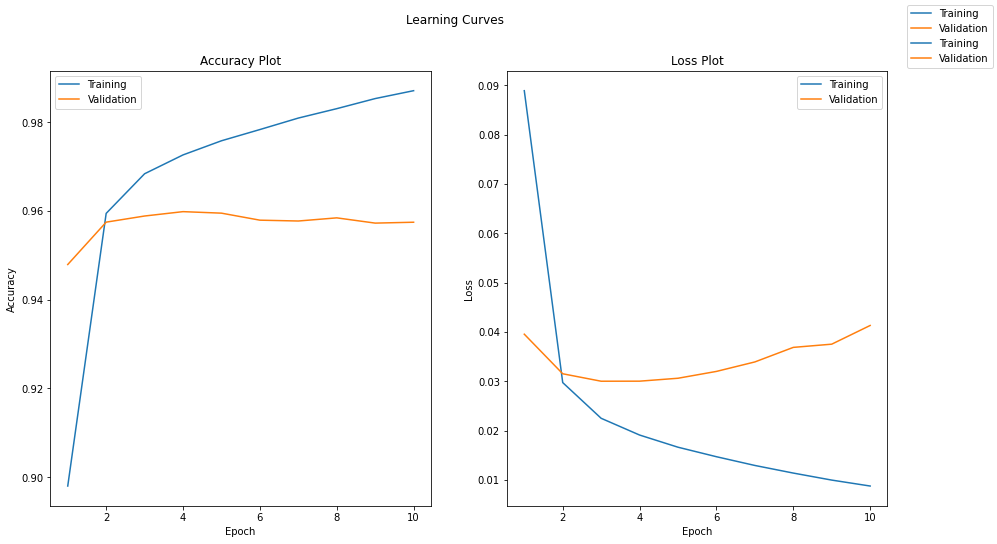

In [42]:
# plot metrics
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
epochs = range(1, EPOCHS+1)
axs[0].plot(epochs, history.history['custom_accuracy'], label='Training')
axs[0].plot(epochs, history.history['val_custom_accuracy'], label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Plot')
axs[0].legend()
# loss
axs[1].plot(epochs, history.history['loss'], label='Training')
axs[1].plot(epochs, history.history['val_loss'], label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Plot')
axs[1].legend()
fig.suptitle('Learning Curves')
fig.legend()


In [43]:
model.evaluate(x=data_test, y=v_tags_test)

150/150 [==============================] - 8s 56ms/step - loss: 0.0415 - accuracy: 0.9563 - sparse_categorical_accuracy: 0.9563 - custom_accuracy: 0.9563 - sparse_categorical_crossentropy: 0.1979


[0.041497524827718735,
 0.9563388228416443,
 0.9563388228416443,
 0.9563388228416443,
 0.19792215526103973]

In [44]:
def predict_tags(sentence):
  print(f"sentence: {sentence}")
  tokenized_sentence = vectorize_sentences(sentences = [sentence])
  # predict
  tags_prob_predicted = model.predict(tokenized_sentence)
  v_tags_predicted = tags_prob_predicted[0].argmax(axis=1)
  tags_predicted = [tags_tokenizer.get_vocabulary()[tag_id] for tag_id in v_tags_predicted]
  return tags_predicted

In [45]:
idx = 10
sentence = sentences_train[idx]
tags_predicted = predict_tags(sentence=sentence)
words = sentence.split(" ")
true_tags = tags_train[idx]
for word, true_tag, pred_tag in zip(words, true_tags, tags_predicted):
  print(f"{word}: {(true_tag, pred_tag)}")

sentence: And Iraq 's military called on Iran to release nine coast guard sailors seized in a dispute on the Shatt al-Arab waterway .
And: ('O', 'O')
Iraq: ('B-geo', 'B-geo')
's: ('O', 'O')
military: ('O', 'O')
called: ('O', 'O')
on: ('O', 'O')
Iran: ('B-geo', 'B-geo')
to: ('O', 'O')
release: ('O', 'O')
nine: ('O', 'O')
coast: ('O', 'O')
guard: ('O', 'O')
sailors: ('O', 'O')
seized: ('O', 'O')
in: ('O', 'O')
a: ('O', 'O')
dispute: ('O', 'O')
on: ('O', 'O')
the: ('O', 'O')
Shatt: ('B-org', 'B-org')
al-Arab: ('I-org', 'I-org')
waterway: ('O', 'O')
.: ('O', 'O')


In [46]:
sentence = "Peter Navarro, the White House director of trade and manufacturing policy of U.S, said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come"
words = sentence.split(" ")
tags_predicted = predict_tags(sentence=sentence)
for word, pred_tag in zip(words, tags_predicted):
  print(f"{word}: {(pred_tag)}")

sentence: Peter Navarro, the White House director of trade and manufacturing policy of U.S, said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come
Peter: B-per
Navarro,: I-per
the: O
White: B-org
House: I-org
director: O
of: O
trade: O
and: O
manufacturing: O
policy: O
of: O
U.S,: O
said: O
in: O
an: O
interview: O
on: O
Sunday: B-tim
morning: I-tim
that: O
the: O
White: B-org
House: I-org
was: O
working: O
to: O
prepare: O
for: O
the: O
possibility: O
of: O
a: O
second: O
wave: O
of: O
the: O
coronavirus: O
in: O
the: O
fall,: O
though: O
he: O
said: O
it: O
wouldn’t: O
necessarily: O
come: O
